In [1]:
import torch
import torchvision
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from collections import defaultdict
from datetime import datetime

from torchvision.datasets import MNIST

from misc.datasets_ae import *

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

import matplotlib.animation
from IPython.display import HTML

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from joblib import Parallel, delayed

import scipy

import seaborn as sns

# seeding
SEED = 91
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
df = pd.read_csv("metrics_600.csv")
df = df.rename(columns={'Unnamed: 0':'idx_orig'})

y = np.hstack((np.zeros(54000), np.ones(3000)))
df['label'] = y

In [4]:
df_loss = pd.read_csv("metrics_losses_600.csv")
df_loss = df_loss.rename(columns={'Unnamed: 0':'idx_orig'})
y = np.hstack((np.zeros(54000), np.ones(3000)))
df_loss['label'] = y

## Correlations with augmentations

In [5]:
corrs = df.corr(method='spearman')
corrs_loss = df_loss.corr(method='spearman')

### Not loss metrics

In [7]:
corrs_metrics_label = abs(corrs.drop('label'))[['label']].sort_values(by='label',ascending=False)
corrs_metrics_label

,label
H__mean_from_0,0.252455
LID__mean_from_10,0.247263
LID__var_from_10,0.236262
LID__std_from_10,0.236262
H__mean_from_400,0.229893
H__last,0.228502
LID__last,0.204978
dif_L2__std_from0,0.173653
dif_L2__var_from0,0.173653
dif_L1__std_from0,0.166482


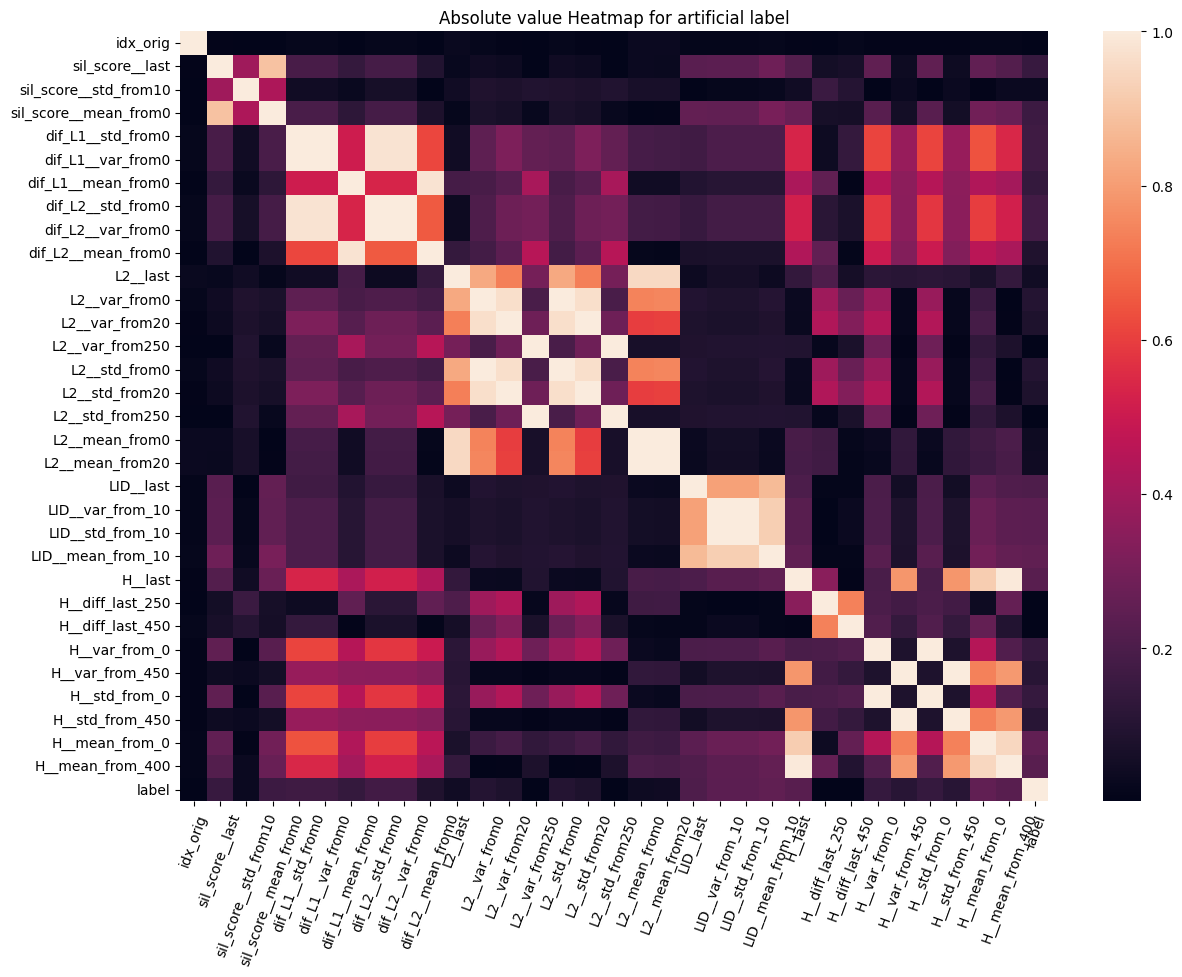

In [8]:
plt.figure(figsize=(14,10))
sns.heatmap(abs(corrs));
plt.title('Absolute value Heatmap for artificial label')
plt.tick_params(axis='x', rotation=70)
plt.show()

### Loss metrics

In [9]:
abs(corrs_loss.drop('label'))[['label']].sort_values(by='label',ascending=False)

,label
loss__last,0.382669
loss__mean_from_50,0.380181
loss__mean_from_20,0.379359
loss__mean_from_0,0.378578
loss__diff_last_20,0.306752
loss__diff_last_50,0.286360
loss__std_from_0,0.276193
loss__var_from_0,0.276193
loss__std_from_20,0.256314
loss__var_from_20,0.256314


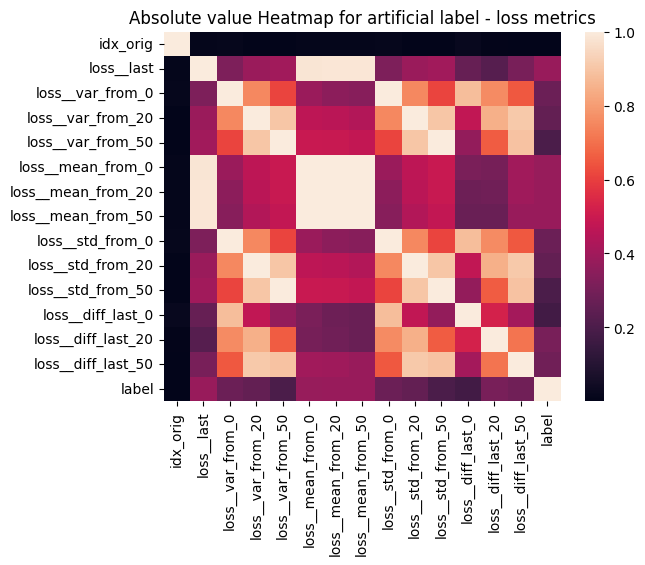

In [10]:
sns.heatmap(abs(corrs_loss));
plt.title('Absolute value Heatmap for artificial label - loss metrics')
plt.show()

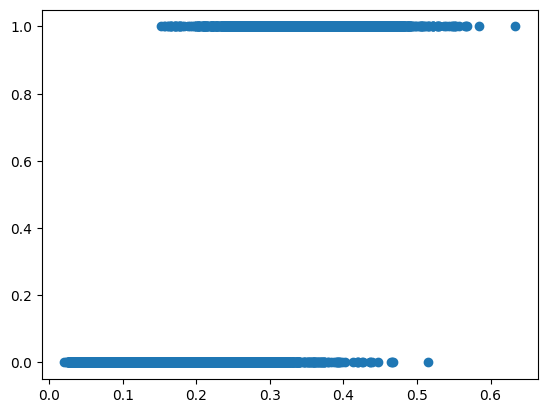

In [11]:
plt.scatter(df_loss['loss__last'], df_loss['label']);

## Correlations with SSFT

In [12]:
df_ssft = pd.read_csv('cnn225k_mnist_sup_both_splits.csv')
df_ssft = df_ssft[df_ssft['is_mislabeled']==False]
df_ssft

,index,sample_idx,scores_learning_time,preds_learning_time,scores_forgetting_time,preds_forgetting_time,original_sample_idx,is_mislabeled,prediction
0,0,26028,59367,59367,3010000,-1,39689,False,typical
1,1,6792,34998,34998,3010000,-1,28623,False,typical
2,2,2966,32257,32257,3010000,-1,58165,False,typical
3,3,27994,36990,3,3010000,-1,15180,False,typical
4,4,13494,47702,47702,3010000,-1,29298,False,typical
...,...,...,...,...,...,...,...,...,...
59995,29995,21594,29995,-1,3010000,0,9761,False,typical
59996,29996,14195,29996,-1,3010000,0,41028,False,typical
59997,29997,14053,29997,-1,3010000,0,3277,False,typical
59998,29998,22408,29998,-1,3010000,0,51903,False,typical


In [13]:
df_wssft = pd.merge(
    left=df.iloc[:-3000],
    right=df_ssft.drop(["index", "sample_idx"], axis=1),
    left_on="idx_orig",
    right_on="original_sample_idx",
)

In [14]:
df_wssft.head()

,idx_orig,sil_score__last,sil_score__std_from10,sil_score__mean_from0,dif_L1__std_from0,dif_L1__var_from0,dif_L1__mean_from0,dif_L2__std_from0,dif_L2__var_from0,dif_L2__mean_from0,...,H__mean_from_0,H__mean_from_400,label,scores_learning_time,preds_learning_time,scores_forgetting_time,preds_forgetting_time,original_sample_idx,is_mislabeled,prediction
0,57443,0.262804,0.130483,0.191395,0.063342,0.004012,0.055012,0.051442,0.002646,0.025485,...,2.241048,2.238999,0.0,21421,21421,3010000,-1,57443,False,typical
1,50575,0.355678,0.069353,0.347673,0.054080,0.002925,0.059930,0.042255,0.001785,0.027226,...,2.246722,2.246592,0.0,3887,-1,3010000,0,50575,False,typical
2,31592,0.326392,0.070500,0.419192,0.052865,0.002795,0.047772,0.037697,0.001421,0.021642,...,2.245862,2.254641,0.0,24234,-1,3010000,0,31592,False,typical
3,53264,0.048783,0.087786,0.074554,0.079364,0.006299,0.057151,0.057435,0.003299,0.026231,...,2.255279,2.260775,0.0,2301941,2301941,3010000,-1,53264,False,atypical
4,22680,0.257922,0.069419,0.262604,0.058440,0.003415,0.048661,0.044096,0.001944,0.022393,...,2.271849,2.282691,0.0,58416,-1,3010000,0,22680,False,typical


### Non-supervised metrics

In [15]:
corr_wssft_cols = \
    df.drop('label', axis=1).columns.to_list() \
    + ['scores_learning_time', 'scores_forgetting_time']

In [16]:
corr_wssft = df_wssft[corr_wssft_cols].corr(method='spearman')

In [17]:
abs(corr_wssft).drop(['idx_orig', 'scores_forgetting_time', 'scores_learning_time'])\
    [['scores_forgetting_time']].sort_values(by='scores_forgetting_time', ascending=False)

,scores_forgetting_time
sil_score__mean_from0,0.079067
LID__mean_from_10,0.076837
sil_score__last,0.075243
LID__std_from_10,0.071935
LID__var_from_10,0.071935
LID__last,0.063683
dif_L1__mean_from0,0.037120
sil_score__std_from10,0.036486
dif_L2__mean_from0,0.027561
H__last,0.017717


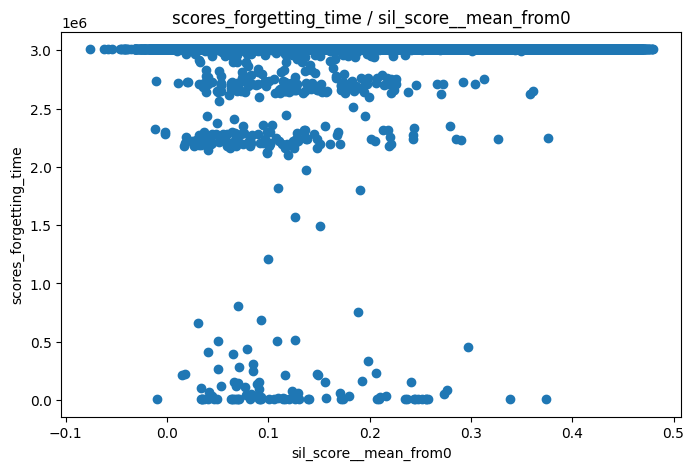

In [18]:
plt.figure(figsize=(8,5))
plt.scatter(df_wssft['sil_score__mean_from0'], df_wssft['scores_forgetting_time']);
plt.title("scores_forgetting_time / sil_score__mean_from0")
plt.xlabel('sil_score__mean_from0')
plt.ylabel('scores_forgetting_time')

plt.show()

In [19]:
abs(corr_wssft).drop(['idx_orig', 'scores_forgetting_time', 'scores_learning_time'])\
    [['scores_learning_time']].sort_values(by='scores_learning_time', ascending=False)

,scores_learning_time
sil_score__mean_from0,0.111911
sil_score__last,0.106541
LID__mean_from_10,0.060681
LID__std_from_10,0.052385
LID__var_from_10,0.052385
sil_score__std_from10,0.051030
LID__last,0.050089
dif_L1__mean_from0,0.033352
H__last,0.031919
H__mean_from_0,0.030239


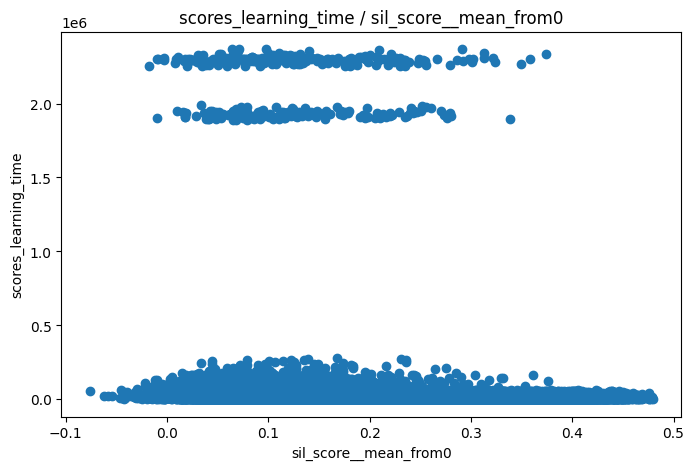

In [20]:
plt.figure(figsize=(8,5))
plt.scatter(df_wssft['sil_score__mean_from0'], df_wssft['scores_learning_time'])
plt.title("scores_learning_time / sil_score__mean_from0")
plt.xlabel('sil_score__mean_from0')
plt.ylabel('scores_learning_time')

plt.show()

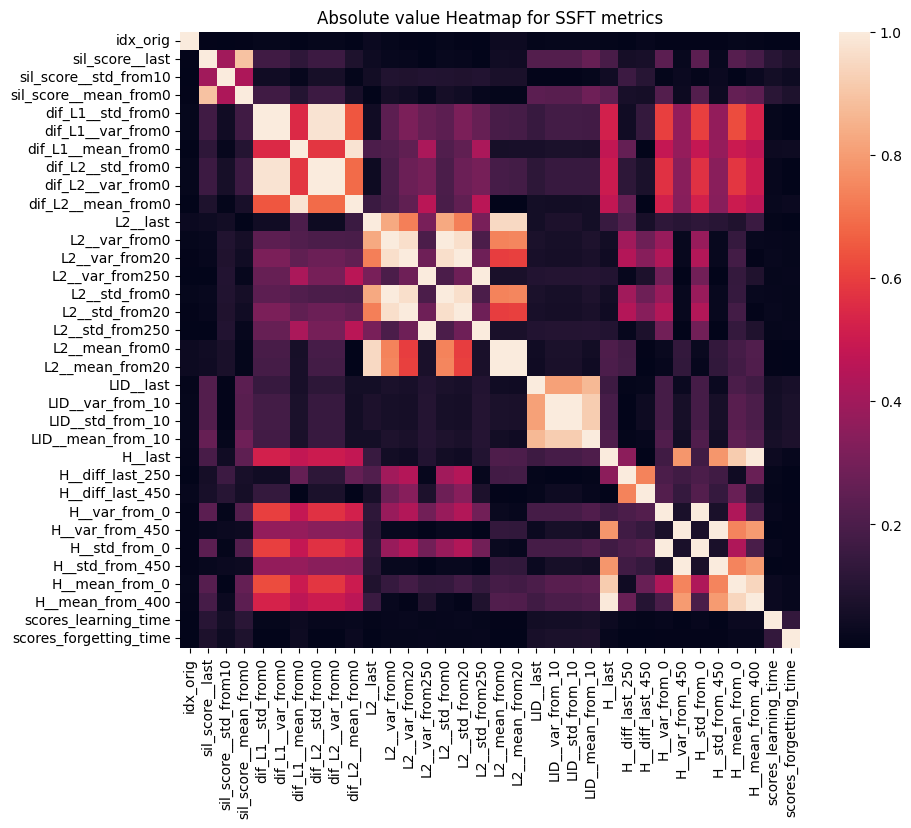

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(abs(corr_wssft));
plt.title('Absolute value Heatmap for SSFT metrics')
plt.show()

### Loss based metrics

In [22]:
df_loss_wssft = pd.merge(
    left=df_loss.iloc[:-3000],
    right=df_ssft.drop(["index", "sample_idx"], axis=1),
    left_on="idx_orig",
    right_on="original_sample_idx",
)

In [23]:
corr_loss_wssft_cols = \
    df_loss.drop('label', axis=1).columns.to_list() \
    + ['scores_learning_time', 'scores_forgetting_time']

In [24]:
corr_loss_wssft = df_loss_wssft[corr_loss_wssft_cols].corr(method='spearman')

In [25]:
abs(corr_loss_wssft).drop(['idx_orig', 'scores_forgetting_time', 'scores_learning_time'])\
    [['scores_forgetting_time']].sort_values(by='scores_forgetting_time', ascending=False)

,scores_forgetting_time
loss__last,0.064331
loss__mean_from_50,0.060538
loss__mean_from_20,0.059442
loss__mean_from_0,0.057004
loss__diff_last_0,0.045001
loss__var_from_0,0.033079
loss__std_from_0,0.033079
loss__diff_last_20,0.017049
loss__diff_last_50,0.012263
loss__var_from_50,0.005655


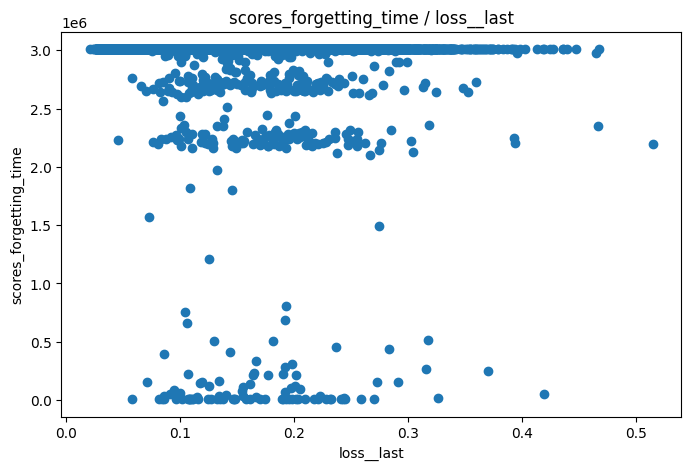

In [26]:
plt.figure(figsize=(8,5))
plt.scatter(df_loss_wssft['loss__last'], df_loss_wssft['scores_forgetting_time']);
plt.title("scores_forgetting_time / loss__last")
plt.xlabel('loss__last')
plt.ylabel('scores_forgetting_time')

plt.show()

In [27]:
abs(corr_loss_wssft).drop(['idx_orig', 'scores_forgetting_time', 'scores_learning_time'])\
    [['scores_learning_time']].sort_values(by='scores_learning_time', ascending=False)

,scores_learning_time
loss__last,0.075337
loss__mean_from_50,0.073484
loss__mean_from_20,0.072327
loss__mean_from_0,0.069063
loss__diff_last_0,0.045606
loss__std_from_0,0.032891
loss__var_from_0,0.032891
loss__std_from_50,0.024004
loss__var_from_50,0.024004
loss__std_from_20,0.011046


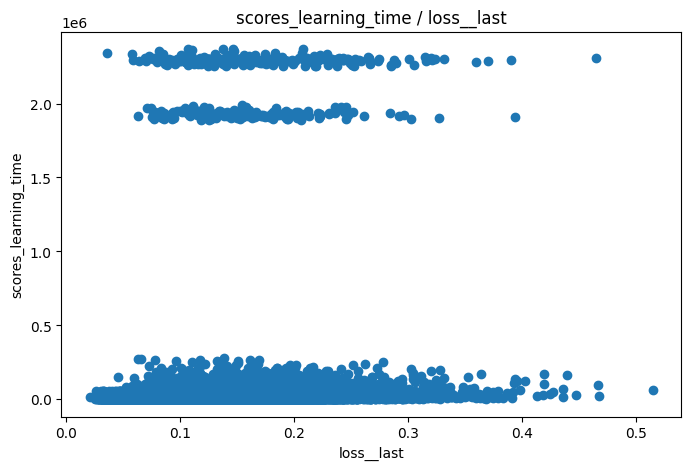

In [28]:
plt.figure(figsize=(8, 5))
plt.scatter(df_loss_wssft['loss__last'], df_loss_wssft['scores_learning_time'])
plt.title("scores_learning_time / loss__last")
plt.xlabel('loss__last')
plt.ylabel('scores_learning_time')

plt.show()